In [1]:
import sys

import keras
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from numpy import array
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # to make any matplotlib plot automatically a 20x10

import configparser
config = configparser.ConfigParser()
config.read('lstmconfig.ini')

scaler = MinMaxScaler(feature_range=(0,1))
eco_tools_path = config['SETUP']['eco_tools_path']
sys.path.append(eco_tools_path)
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')

callbacks_list = [EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=2)]

Using TensorFlow backend.


In [2]:
point_name = config['PI']['point_name']
start = config['PI']['start']
end = config['PI']['end']
interval = config['PI']['interval']
calculation = config['PI']['calculation']

In [100]:
def create_mulitvariable_df(data):
    data.rename(columns={'aiTIT4045':'OAT'}, inplace=True)

    data["cdd"] = data.OAT - 65.0
    data.loc[data.cdd < 0, "cdd"] = 0
    data["hdd"] = 65.0 - data.OAT
    data.loc[data.hdd < 0, 'hdd'] = 0
    data["cdd2"] = data.cdd**2
    data["hdd2"] = data.hdd**2

    data2 = data.copy()
    ##FIX: if the dataframe passed does not have a month that the origial LSTM trained on, it wont be able
    ##to be used to predict!
    data2["MONTH"]= data2.index.month
    data2["MONTH"] = data2["MONTH"].astype('category')
    data2["TOD"] = data2.index.hour
    data2["TOD"] = data2["TOD"].astype('category')
    data2["DOW"] = data2.index.weekday
    data2["DOW"] = data2["DOW"].astype('category')
    print(f"data2: {data2['MONTH'].unique()}")
    ### Create dummy variables
    l3 = ["MONTH","TOD","DOW"]#,“WEEK”]#,“DOY”]
    data2 = pd.get_dummies(data=data2, columns=l3, drop_first=True)
 
    ### Create Weekend flag
    data2["WEEKEND"] = 0
    data2.loc[(data2.DOW_5 == 1) | (data2.DOW_6 == 1), 'WEEKEND'] = 1
    
    data2["shift1"] = data2.iloc[:,0].shift(2)

    data2["rolling24_mean"] = data2.iloc[:,0].rolling('24h').mean()
    data2["rolling24_max"] = data2.iloc[:,0].rolling('24h').max()
    data2["rolling24_min"] = data2.iloc[:,0].rolling('24h').min()
   
    data2.dropna(inplace=True)
    
    return data2

In [101]:
point_list = [point_name, 'aiTIT4045']
df = pc.get_stream_by_point(point_list, start = start, end = end, calculation = calculation, interval= interval)
df = df.dropna(how='any')
df.head()

Grabbing WebIDs ...
WebID collection complete!
16:22:02: Sending API request... Chunk 1 of 1
16:22:04: Response recieved for 2 tags! (2.5)


/Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1027: FutureWarning: The errors argument is deprecated and will be removed in a future release. Use nonexistent='NaT' or nonexistent='raise' instead.
  "instead.", FutureWarning)


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2016-01-01 00:00:00,2550.633333,40.409643
2016-01-01 01:00:00,2535.975618,40.079128
2016-01-01 02:00:00,2538.258333,40.090998
2016-01-01 03:00:00,2548.635795,40.114107
2016-01-01 04:00:00,2556.464644,39.902123


In [102]:
def clean_train_data(df):
    mask1 = (df[point_name] > 2400 )& (df.index.year < 2019)
    df1 = df.loc[mask1]
    mask2 = (df.index.year>=2019)
    df2 = df.loc[mask2]
    return df1, df2
    #return pd.concat([df1,df2])   

In [103]:
df, df1 = clean_train_data(df)
print(f"df: {df.shape} \n df1: {df1.shape}")

df: (26114, 2) 
 df1: (4705, 2)


In [104]:
df = create_mulitvariable_df(df)
df1 = create_mulitvariable_df(df1)
df.head()

data2: [1, 2, 3, 4, 5, ..., 8, 9, 10, 11, 12]
Length: 12
Categories (12, int64): [1, 2, 3, 4, ..., 9, 10, 11, 12]
data2: [1, 2, 3, 4, 5, 6, 7]
Categories (7, int64): [1, 2, 3, 4, 5, 6, 7]


,GBSF_Electricity_Demand_kBtu,OAT,cdd,hdd,cdd2,hdd2,MONTH_2,MONTH_3,MONTH_4,MONTH_5,...,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,WEEKEND,shift1,rolling24_mean,rolling24_max,rolling24_min
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 02:00:00,2538.258333,40.090998,0.0,24.909002,0.0,620.458395,0,0,0,0,...,0,0,1,0,0,0,2550.633333,2541.622428,2550.633333,2535.975618
2016-01-01 03:00:00,2548.635795,40.114107,0.0,24.885893,0.0,619.307679,0,0,0,0,...,0,0,1,0,0,0,2535.975618,2543.375770,2550.633333,2535.975618
2016-01-01 04:00:00,2556.464644,39.902123,0.0,25.097877,0.0,629.903431,0,0,0,0,...,0,0,1,0,0,0,2538.258333,2545.993545,2556.464644,2535.975618
2016-01-01 05:00:00,2541.260449,39.394233,0.0,25.605767,0.0,655.655326,0,0,0,0,...,0,0,1,0,0,0,2548.635795,2545.204696,2556.464644,2535.975618
2016-01-01 06:00:00,2569.566667,38.751869,0.0,26.248131,0.0,688.964360,0,0,0,0,...,0,0,1,0,0,0,2556.464644,2548.684977,2569.566667,2535.975618


In [105]:
df2.columns

Index(['GBSF_Electricity_Demand_kBtu', 'OAT', 'cdd', 'hdd', 'cdd2', 'hdd2',
       'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7',
       'TOD_1', 'TOD_2', 'TOD_3', 'TOD_4', 'TOD_5', 'TOD_6', 'TOD_7', 'TOD_8',
       'TOD_9', 'TOD_10', 'TOD_11', 'TOD_12', 'TOD_13', 'TOD_14', 'TOD_15',
       'TOD_16', 'TOD_17', 'TOD_18', 'TOD_19', 'TOD_20', 'TOD_21', 'TOD_22',
       'TOD_23', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6',
       'WEEKEND', 'shift1', 'rolling24_mean', 'rolling24_max',
       'rolling24_min'],
      dtype='object')

In [106]:
np.setdiff1d(df.columns,df2.columns)


array(['MONTH_10', 'MONTH_11', 'MONTH_12', 'MONTH_8', 'MONTH_9'],
      dtype=object)

In [107]:
def scale_keras(X, y):
    # normalize the dataset
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler((0, 1))
    X = scaler_x.fit_transform(X)
    y = scaler_y.fit_transform(np.array(y).reshape((-1,1)))
    # split into train and test sets
    train_size = int(len(X) * 0.7)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size], X[test_size:len(X)]
    y_train, y_test = y[0:train_size], y[test_size:len(y)]
    return X_train, X_test, y_train, y_test, scaler_x, scaler_y

In [108]:
y = df[point_name]
X = df.drop(columns=point_name)
y1 = df1[point_name]
X1 = df1.drop(columns=point_name)

In [109]:
X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_keras(X, y)
X1_train, X1_test, y1_train, y1_test, scaler_x1, scaler_y1 = scale_keras(X1, y1)

In [110]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X1_train = np.reshape(X1_train, (X1_train.shape[0], 1, X1_train.shape[1]))
X1_test = np.reshape(X1_test, (X1_test.shape[0], 1, X1_test.shape[1]))

In [111]:
train = DataFrame()
val = DataFrame()
np.random.seed(42)
for i in range(1):
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
    model.add(LSTM(100))
    model.add(Dense(1))
    model.compile(optimizer = Adam(lr = 0.001), loss = 'mean_squared_error')
    #X,y = get_train()
    #valX, valY = get_val()
    # fit model
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.3, shuffle = False)
    # story history
    train[str(i)] = history.history['loss']
    val[str(i)] = history.history['val_loss']



Train on 12794 samples, validate on 5484 samples
Epoch 1/100
12794/12794 [==============================] - 3s 231us/step - loss: 0.0103 - val_loss: 0.0042
Epoch 2/100
12794/12794 [==============================] - 2s 134us/step - loss: 0.0027 - val_loss: 0.0039
Epoch 3/100
12794/12794 [==============================] - 2s 137us/step - loss: 0.0031 - val_loss: 0.0131
Epoch 4/100
12794/12794 [==============================] - 2s 137us/step - loss: 0.0028 - val_loss: 0.0181
Epoch 5/100
12794/12794 [==============================] - 2s 140us/step - loss: 0.0027 - val_loss: 0.0187
Epoch 6/100
12794/12794 [==============================] - 2s 137us/step - loss: 0.0025 - val_loss: 0.0186
Epoch 7/100
12794/12794 [==============================] - 2s 137us/step - loss: 0.0025 - val_loss: 0.0182
Epoch 8/100
12794/12794 [==============================] - 2s 133us/step - loss: 0.0025 - val_loss: 0.0177
Epoch 9/100
12794/12794 [==============================] - 2s 138us/step - loss: 0.0025 - val_l

12794/12794 [==============================] - 2s 140us/step - loss: 9.8190e-04 - val_loss: 0.0029
Epoch 77/100
12794/12794 [==============================] - 2s 136us/step - loss: 9.7388e-04 - val_loss: 0.0029
Epoch 78/100
12794/12794 [==============================] - 2s 132us/step - loss: 9.6758e-04 - val_loss: 0.0029
Epoch 79/100
12794/12794 [==============================] - 2s 132us/step - loss: 9.6101e-04 - val_loss: 0.0029
Epoch 80/100
12794/12794 [==============================] - 2s 141us/step - loss: 9.5429e-04 - val_loss: 0.0028
Epoch 81/100
12794/12794 [==============================] - 2s 140us/step - loss: 9.4698e-04 - val_loss: 0.0028
Epoch 82/100
12794/12794 [==============================] - 2s 136us/step - loss: 9.4030e-04 - val_loss: 0.0028
Epoch 83/100
12794/12794 [==============================] - 2s 134us/step - loss: 9.3259e-04 - val_loss: 0.0028
Epoch 84/100
12794/12794 [==============================] - 2s 133us/step - loss: 9.2559e-04 - val_loss: 0.0028
Epoch

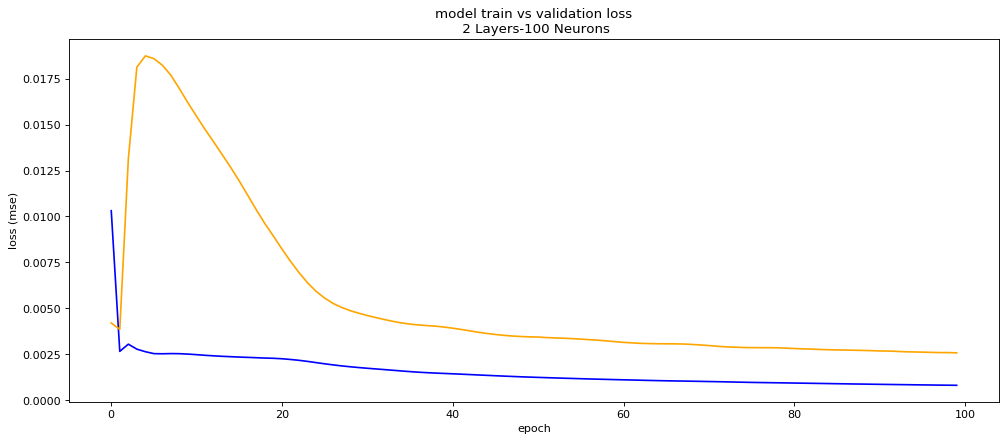

In [112]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train, color='blue', label='train')
plt.plot(val, color='orange', label='validation')
plt.title('model train vs validation loss\n 2 Layers-100 Neurons')
plt.ylabel('loss (mse)')
plt.xlabel('epoch')
#plt.savefig('new_300_epochs.png')
plt.show()

R2 of train = 0.963
R2 of test = 0.951

RMSE of train = 45.531
RMSE of test = 52.204

MAE of train = -5.26
MAE of test = -8.175


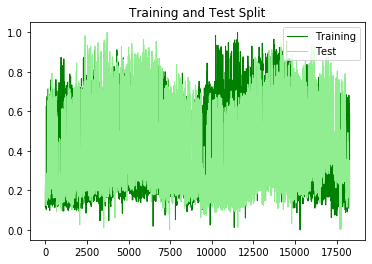

<Figure size 1296x144 with 0 Axes>

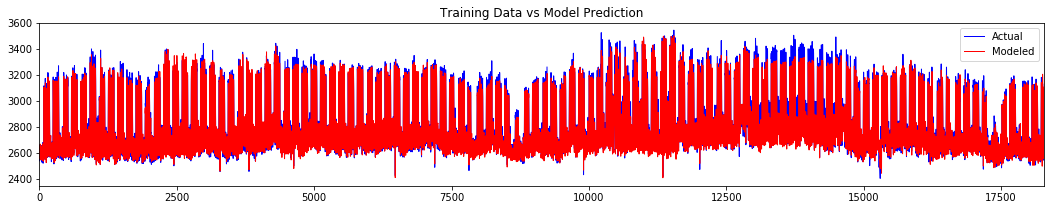

<Figure size 1296x144 with 0 Axes>

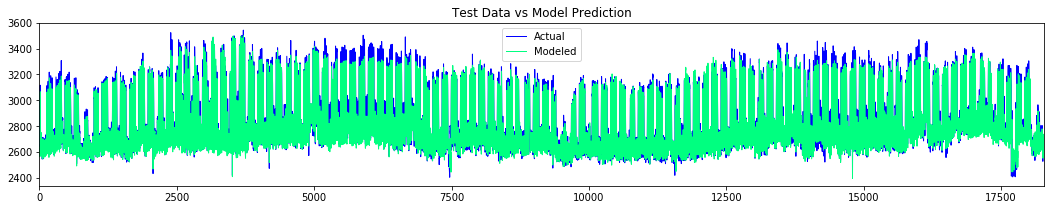

In [113]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
plt.plot(y_train, linewidth=1, color='green')
plt.plot(y_test, color='lightgreen', linewidth=1)
plt.title("Training and Test Split")
plt.legend(['Training','Test'])

pred_train = history.model.predict(X_train)
pred_train_inv = scaler_y.inverse_transform(pred_train.reshape(-1,1))
pred_test = history.model.predict(X_test)
pred_test_inv = scaler_y.inverse_transform(pred_test.reshape(-1,1))

plt.figure(figsize=(18,2))
training_comparison = pd.DataFrame({"Actual":scaler_y.inverse_transform(y_train).reshape((-1,)),
                                   "Modeled":pred_train_inv.reshape((-1,))}, index=range(len(y_train)))
training_comparison.sort_index().plot(figsize=(18,3),
                         title="Training Data vs Model Prediction",
                         linewidth=1,
                         color=['blue','red'])
 
plt.figure(figsize=(18,2))
test_comparison = pd.DataFrame({"Actual":scaler_y.inverse_transform(y_test).reshape((-1,)),
                                   "Modeled":pred_test_inv.reshape((-1,))}, index=range(len(y_test)))
test_comparison.sort_index().plot(figsize=(18,3),
                     title="Test Data vs Model Prediction",
                     linewidth=1,
                     colormap='winter')

r2_train = r2_score(scaler_y.inverse_transform(y_train).reshape((-1,)), pred_train_inv.reshape(-1,1))
print(f"R2 of train = {round(r2_train,3)}")
r2_test = r2_score(scaler_y.inverse_transform(y_test).reshape((-1,)), pred_test_inv.reshape(-1,1))
print(f"R2 of test = {round(r2_test,3)}")
print()
rmse_train = math.sqrt(mean_squared_error(scaler_y.inverse_transform(y_train).reshape((-1,)), pred_train_inv.reshape(-1,1)))
print(f"RMSE of train = {round(rmse_train,3)}")
rmse_test = math.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test).reshape((-1,)), pred_test_inv.reshape(-1,1)))
print(f"RMSE of test = {round(rmse_test,3)}")
print()
mae_train = np.median((pred_train_inv.reshape(-1,1) - scaler_y.inverse_transform(y_train).reshape((-1,))))
print(f"MAE of train = {round(mae_train,3)}")
mae_test = np.median((pred_test_inv.reshape(-1,1) - scaler_y.inverse_transform(y_test).reshape((-1,))))
print(f"MAE of test = {round(mae_test,3)}")